# explore the extended kalman filter data

````
Data Flow:
1) The measuremennt processor/matlab simulator is generating the FUSION .txt file:
	"data/obj_pose-laser-radar-synthetic-ukf-input.txt";
	OR
	"../matlab_examples/obj_pose-laser-radar-synthetic-ukf-input.txt";

The Input file format is:
#L(for laser) meas_px meas_py timestamp gt_px gt_py gt_vx gt_vy
#R(for radar) meas_rho meas_phi meas_rho_dot timestamp gt_px gt_py gt_vx gt_vy

Example:
R	8.60363	0.0290616	-2.99903	1477010443399637	8.6	0.25	-3.00029	0
L	8.45	0.25	1477010443349642	8.45	0.25	-3.00027	0
	
2) The EKF Algorithm reads form file reads all the lines and generates measurement structures
3) The MeasurementProcessor() is called with individual measurements (one by one). The results are saved
(Attention: no file processing routines are used inside MeasurementProcessor() all the file processing routines are in the main function
So the data read/write is decoupled from the algorithm
4) The results are saved in an output file:
"data/obj_pose-laser-radar-ekf-output.txt"

Output file format:
est_px est_py est_vx est_vy meas_px meas_py gt_px gt_py gt_vx gt_vy

Example:
4.53271	0.279	-0.842172	53.1339	4.29136	0.215312	2.28434	0.226323
43.2222	2.65959	0.931181	23.2469	4.29136	0.215312	2.28434	0.226323
````

In [704]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import datetime
import math
import random
import csv

%matplotlib inline

In [705]:
raw_data = []
with open('data/obj_pose-laser-radar-synthetic-input.txt', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        raw_data.append(row)

In [706]:
def polar_to_cartesian(polar_x):
    rho, phi, drho = polar_x[0], polar_x[1], polar_x[2]
    
    px = rho * math.cos(phi)
    py = rho * math.sin(phi)
    vx = drho * math.cos(phi)
    vy = drho * math.sin(phi)
    
    return np.array([px, py, vx, vy])
    

In [707]:
def cartesian_to_polar(cartesian_x_):
    THRESH = 0.0001;
    cartesian_x = cartesian_x_.flatten()
    px, py, vx, vy = cartesian_x[0], cartesian_x[1], cartesian_x[2], cartesian_x[3]
    rho = math.sqrt(px**2 + py**2)
    phi = math.atan2(py, px)
    drho = 0
    if rho > THRESH: drho = (px*vx + py*vy) / rho
    
    return np.array([rho, phi, drho])

In [708]:
def get_jacobian_from_state(cartesian_x_):
    cartesian_x = cartesian_x_.flatten()
    px, py, vx, vy = cartesian_x[0], cartesian_x[1], cartesian_x[2], cartesian_x[3]
    
    
    px2_plus_py2 = px**2 + py**2
    on_sqrt = math.sqrt(px2_plus_py2)
    on_3_per_2 = math.pow(px2_plus_py2, 3/2)
    
    vi1 = py * (vx*py - vy*px) / on_3_per_2
    vi2 = px * (vy*px - vx*py) / on_3_per_2
    
    Hj = np.array([[px / on_sqrt,        py / on_sqrt,      0,             0]
                  ,[-py / px2_plus_py2,  px / px2_plus_py2, 0,             0]
                  ,[vi1,                 vi2,               px / on_sqrt,  py / on_sqrt ]
                  ])
    return Hj
    
    

In [846]:
class Kalman():
    def __init__(self):
        self.x = np.array([[0], 
                           [0],
                           [0],
                           [0]]) # initial state (location and velocity)
        self.reset()
        
    def reset(self):
        self.P = np.array([[1000., 0., 0., 0.], 
                           [0., 1000., 0., 0.],
                           [0., 0., 1000., 0.],
                           [0., 0., 0., 1000.]]) # initial uncertainty
        
        self.u = np.array([[0], [0], [0], [0]]) # external motion
        
        self.F = np.array([[1, 0, 1, 0], 
                           [0, 1, 0, 1],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]]) # next state function
               
        self.I = np.array([[1, 0, 0, 0], 
                           [0, 1, 0, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]]) # identity matrix      
        
    def feed_meas_L(self, measurement): 
        #print('------ L ---------')
        z = np.array(measurement).reshape((2,-1)) # z - measurement matrix
        H = np.array([[1, 0, 0, 0] # X to measurement mapping matrix (H * x = measurement)
                          ,[0, 1, 0, 0]])
        R = np.array([[0.000125, 0 ]
                     ,[0, 0.000125]])
        
        Hx = H.dot(self.x)
    
        self.process_meas(z, H, Hx, R)
        

    def feed_meas_R(self, measurement):
        #print('------ R ---------')
        z = np.array(measurement).reshape((3,-1)) # z - measurement matrix
        H = get_jacobian_from_state(polar_to_cartesian(measurement))
        R =  np.array([[3, 0, 0]
                     , [0, 3, 0]
                     , [0, 0, 0.5]])
        
        Hx = cartesian_to_polar(self.x).reshape(3,1)
        
        self.process_meas(z, H, Hx, R)

    def process_meas(self, z, H, Hx, R):

        y = z - Hx # error : previous state - measurement X measurement matrix
        #print ('z', z)
        #print ('y', y)
        S = H.dot(self.P).dot(H.transpose()) + R
        #print ('S', S)
        K = self.P.dot(H.transpose()).dot(np.linalg.inv(S)) # kalman gain
        #print('K', K)
        self.x = self.x + K.dot(y) # new state : x + kalman gain X error
        #print ('self.x', self.x)
        self.P = np.dot((self.I - K.dot(H)), self.P) # + self.Q # adjusting uncertainty covaria       
        #print ('self.P', self.P)
        
    def predict_next_state(self): 
        self.x = np.dot(self.F, self.x) #+ self.u # new state : movement matrix X current state + movement
        self.P = np.dot(np.dot(self.F, self.P), self.F.transpose()) + self.Q # adjusting covar matrix
       
    def update_F(self, dt):
        self.F[0, 2] = dt;
        self.F[1, 3] = dt;      
        
    def update_Q(self, dt):
        ##### covariance uncertainity Q
        ##### values coming from decomposing the acceleration component in the kin.equatations
        axsig = 0.001
        aysig = 0.001
        dt4_per_4 = dt**4/4
        dt3_per_2 = dt**3/2
        dt2 = dt**2
        
        self.Q = np.array([[dt4_per_4*axsig, 0, dt3_per_2*axsig, 0]
                    ,[0, dt4_per_4*aysig, 0, dt3_per_2*aysig]
                    ,[dt3_per_2*axsig, 0, dt2*axsig, 0]
                    ,[0, dt3_per_2*aysig, 0, dt2*aysig]]
                    );   
        
        
        
def calculate_RMSE(truth_, pred_):
    truth = np.array(truth_).reshape(-1,4).astype(float)   
    pred = np.array(pred_).reshape(-1,4).astype(float)
    
    truth = truth[:,0:2]
    pred = pred[:,0:2]
    return np.sqrt(np.sum((truth - pred)**2, axis=1))




pred_list = []
l_meas_list = []
r_meas_list = []
truth_list = []
i = 1
k = Kalman()
timestamp = 0
for p in raw_data:
    i += 1
    if p[0] == 'L':
        ## lidar
        
        #if (i%3 == 0) : continue
        x, y = float(p[1]), float(p[2])
        dt = (int(p[3]) - timestamp) / 100000
        
        #dt += random.random() / 10 - 0.05
        timestamp = int(p[3])

        k.update_Q(dt)
        k.update_F(dt)
        k.predict_next_state()
        k.feed_meas_L([x,y])
        
        l_meas_list.append([x,y])
        
        pred_list.append(k.x)
        truth_list.append(p[4:8])

    else:
        #continue
        ## radar
        rho, phi, drho = float(p[1]), float(p[2]), float(p[3])
        dt = (int(p[4]) - timestamp) / 100000
        
        dt += random.random() / 10 - 0.05

        timestamp = int(p[4])
        
        k.update_Q(dt)
        k.update_F(dt)
        k.predict_next_state()        
        cartesian = polar_to_cartesian([rho, phi, drho])
        #k.feed_meas_L([cartesian[0], cartesian[1]])
        k.feed_meas_R([rho, phi, drho])
                        
        r_meas_list.append(polar_to_cartesian([rho, phi, drho]))
        
        pred_list.append(k.x)
        truth_list.append(p[5:9])

        
        


pred_list = np.array(pred_list)
l_meas_list = np.array(l_meas_list)
r_meas_list = np.array(r_meas_list)
truth_list = np.array(truth_list)

RMSE = calculate_RMSE(truth_list, pred_list)
print ('RMSE', np.sum(RMSE) / len(RMSE))

RMSE 0.908882543446


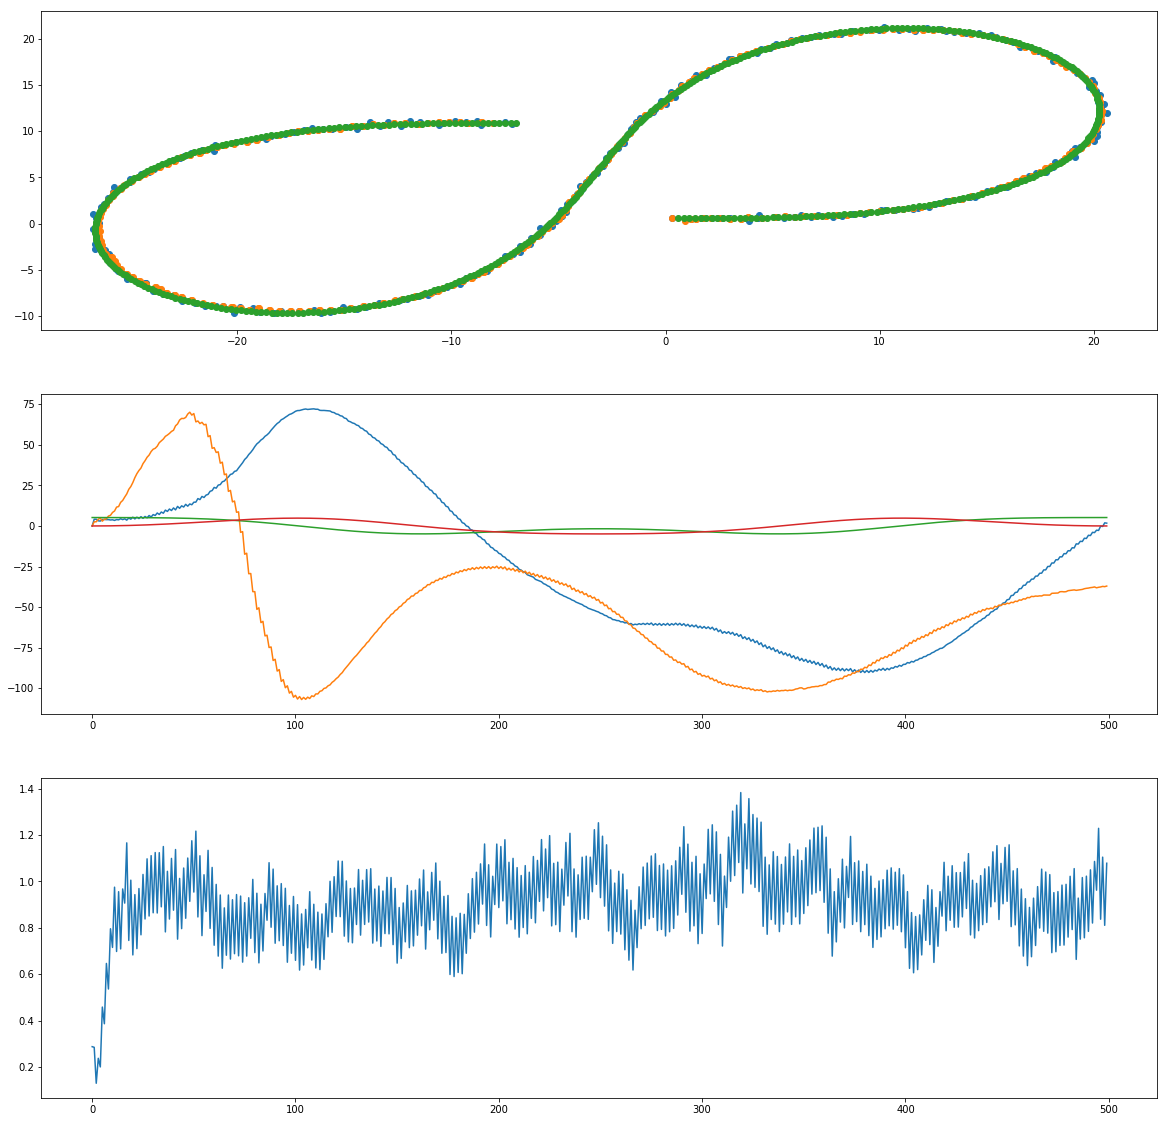

In [847]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.scatter(l_meas_list[:,0], l_meas_list[:,1])
#plt.scatter(r_meas_list[:,0], r_meas_list[:,1])
plt.scatter(pred_list[:,0][:], pred_list[:,1][:])
plt.scatter(truth_list[:,0], truth_list[:,1])

plt.subplot(3,1,2)
plt.plot(pred_list[:,2])
plt.plot(pred_list[:,3])
plt.plot(truth_list[:,2])
plt.plot(truth_list[:,3])

plt.subplot(3,1,3)
plt.plot(RMSE)
